In [13]:
from torch.utils.data import DataLoader, Dataset
import torch
import torchvision.transforms as transforms
import numpy as np
import torch.nn as nn
from tqdm import tqdm
import os
import cv2
import matplotlib.pyplot as plt

In [14]:
device = torch.device("cpu")

In [15]:
transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

class FrameInterpolationDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []

        for subdir in sorted(os.listdir(root_dir))[:129]:
            subdir_path = os.path.join(root_dir, subdir)

            frame_path1 = os.path.join(subdir_path, "frame1.jpg")
            frame_path2 = os.path.join(subdir_path, "frame2.jpg")
            frame_path3 = os.path.join(subdir_path, "frame3.jpg")

            frame1 = cv2.imread(frame_path1)
            frame2 = cv2.imread(frame_path2)
            frame3 = cv2.imread(frame_path3)

            self.samples.append((frame1, frame2, frame3))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        frame1, frame2, frame3 = self.samples[idx]

        if self.transform:
            frame1 = self.transform(frame1)
            frame2 = self.transform(frame2)
            frame3 = self.transform(frame3)

        x = (frame1, frame3)
        y = frame2
        return x, y

In [16]:
images_train = FrameInterpolationDataset("./atd_12k/datasets/train_128px", transform=transform)

In [17]:
trainloader = DataLoader(images_train, batch_size=2, shuffle=True, num_workers=4)

In [18]:
def show(img, denormalize=False):
    if denormalize:
        img = (img + 1) / 2
        img = np.transpose(img, (1, 2, 0))
        
    plt.imshow(img)
    plt.axis('off')
    plt.show()

def show_3_frames(x, y):
    fig, axes = plt.subplots(1, 3, figsize=(10, 3))

    img = x[0]
    img = (img + 1) / 2
    img = np.transpose(img, (1, 2, 0))
    img = (img.numpy() * 255).astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[0].imshow(img)

    img = y
    img = (img + 1) / 2
    img = np.transpose(img, (1, 2, 0))
    img = (img.numpy() * 255).astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[1].imshow(img)

    img = x[1]
    img = (img + 1) / 2
    img = np.transpose(img, (1, 2, 0))
    img = (img.numpy() * 255).astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[2].imshow(img)

    plt.show()

In [19]:
x, y = images_train[30]

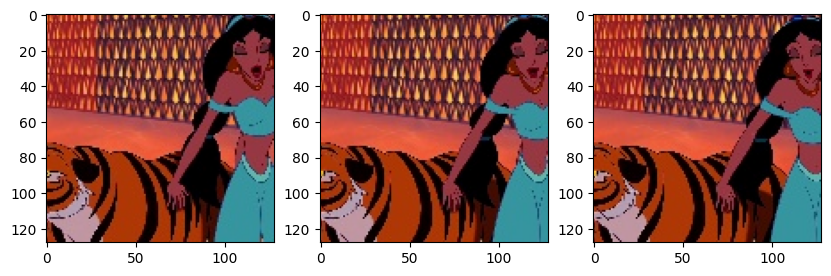

In [20]:
show_3_frames(x, y)

Wykorzystany memflow do generowania optical flow


github.com/DQiaole/MemFlow

In [21]:
from my_evaluate import generates_flow

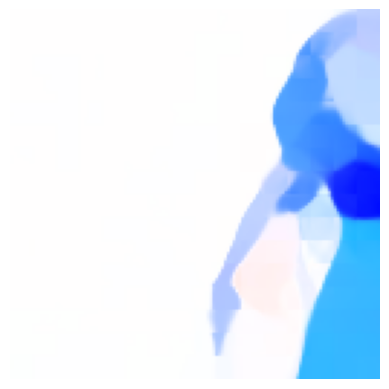

In [22]:
a = generates_flow(x[1], x[0])

show(a)

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import sys
import argparse

from forward_wrap import ForwardWarp
from GridNet import GridNet


class FeatureExtractor(nn.Module):
    """The quadratic model"""
    def __init__(self, path='./network-default.pytorch'):
        super(FeatureExtractor, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.prelu1 = nn.PReLU()
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.prelu2 = nn.PReLU()
        self.conv3 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.prelu3 = nn.PReLU()
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
        self.prelu4 = nn.PReLU()
        self.conv5 = nn.Conv2d(64, 96, 3, stride=2, padding=1)
        self.prelu5 = nn.PReLU()
        self.conv6 = nn.Conv2d(96, 96, 3, padding=1)
        self.prelu6 = nn.PReLU()

    def forward(self, x):
        x = self.prelu1(self.conv1(x))
        x1 = self.prelu2(self.conv2(x))
        x = self.prelu3(self.conv3(x1))
        x2 = self.prelu4(self.conv4(x))
        x = self.prelu5(self.conv5(x2))
        x3 = self.prelu6(self.conv6(x))

        return x1, x2, x3


class AnimeInterp(nn.Module):
    """The quadratic model"""
    def __init__(self):
        super(AnimeInterp, self).__init__()

        args = argparse.Namespace()
        args.small = False
        args.mixed_precision = False
        # args.requires_sq_flow = False

        self.feat_ext = FeatureExtractor()
        self.fwarp = ForwardWarp()
        self.synnet = GridNet(6, 64, 128, 96*2, 3)

    def dflow(self, flo, target):
        tmp = F.interpolate(flo, target.size()[2:4])
        tmp[:, :1] = tmp[:, :1].clone() * tmp.size()[3] / flo.size()[3]
        tmp[:, 1:] = tmp[:, 1:].clone() * tmp.size()[2] / flo.size()[2]

        return tmp
    def forward(self, I1, I2, F12, F21, t=0.5):
        r = 0.6

        # I1 = I1[:, [2, 1, 0]]
        # I2 = I2[:, [2, 1, 0]]


        # extract features
        I1o = (I1 - 0.5) / 0.5
        I2o = (I2 - 0.5) / 0.5

        feat11, feat12, feat13 = self.feat_ext(I1o)
        feat21, feat22, feat23 = self.feat_ext(I2o)

        F1t = t * F12
        F2t = (1-t) * F21

        F1td = self.dflow(F1t, feat11)
        F2td = self.dflow(F2t, feat21)

        F1tdd = self.dflow(F1t, feat12)
        F2tdd = self.dflow(F2t, feat22)

        F1tddd = self.dflow(F1t, feat13)
        F2tddd = self.dflow(F2t, feat23)

        # warping 
        one0 = torch.ones(I1.size(), requires_grad=True)
        one1 = torch.ones(feat11.size(), requires_grad=True)
        one2 = torch.ones(feat12.size(), requires_grad=True)
        one3 = torch.ones(feat13.size(), requires_grad=True)

        I1t = self.fwarp(I1, F1t)
        feat1t1 = self.fwarp(feat11, F1td)
        feat1t2 = self.fwarp(feat12, F1tdd)
        feat1t3 = self.fwarp(feat13, F1tddd)

        I2t = self.fwarp(I2, F2t)
        feat2t1 = self.fwarp(feat21, F2td)
        feat2t2 = self.fwarp(feat22, F2tdd)
        feat2t3 = self.fwarp(feat23, F2tddd)

        norm1 = self.fwarp(one0, F1t.clone())
        norm1t1 = self.fwarp(one1, F1td.clone())
        norm1t2 = self.fwarp(one2, F1tdd.clone())
        norm1t3 = self.fwarp(one3, F1tddd.clone())

        norm2 = self.fwarp(one0, F2t.clone())
        norm2t1 = self.fwarp(one1, F2td.clone())
        norm2t2 = self.fwarp(one2, F2tdd.clone())
        norm2t3 = self.fwarp(one3, F2tddd.clone())

        # normalize
        # Note: normalize in this way benefit training than the original "linear"
        I1t[norm1 > 0] = I1t.clone()[norm1 > 0] / norm1[norm1 > 0]
        I2t[norm2 > 0] = I2t.clone()[norm2 > 0] / norm2[norm2 > 0]
        
        feat1t1[norm1t1 > 0] = feat1t1.clone()[norm1t1 > 0] / norm1t1[norm1t1 > 0]
        feat2t1[norm2t1 > 0] = feat2t1.clone()[norm2t1 > 0] / norm2t1[norm2t1 > 0]
        
        feat1t2[norm1t2 > 0] = feat1t2.clone()[norm1t2 > 0] / norm1t2[norm1t2 > 0]
        feat2t2[norm2t2 > 0] = feat2t2.clone()[norm2t2 > 0] / norm2t2[norm2t2 > 0]
        
        feat1t3[norm1t3 > 0] = feat1t3.clone()[norm1t3 > 0] / norm1t3[norm1t3 > 0]
        feat2t3[norm2t3 > 0] = feat2t3.clone()[norm2t3 > 0] / norm2t3[norm2t3 > 0]


        # synthesis
        It_warp = self.synnet(torch.cat([I1t, I2t], dim=1), torch.cat([feat1t1, feat2t1], dim=1), torch.cat([feat1t2, feat2t2], dim=1), torch.cat([feat1t3, feat2t3], dim=1))



        return It_warp

In [24]:
import torch.optim as optim

model = AnimeInterp().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.L1Loss()

for epoch in range(10):
    model.train()
    total_loss = 0

    for x, y in tqdm(trainloader):
        I0, I1 = x

        I0 = I0.to(device)
        I1 = I1.to(device)
        y = y.to(device)

        flows_f0_1 = []
        flows_f1_0 = []

        for i in range(I0.size(0)):
            f0_1_np = generates_flow(I0[i], I1[i])[:, :, :2]
            f1_0_np = generates_flow(I1[i], I0[i])[:, :, :2]

            flows_f0_1.append(torch.tensor(f0_1_np))
            flows_f1_0.append(torch.tensor(f1_0_np))

        f0_1 = torch.stack(flows_f0_1).permute(0, 3, 1, 2).to(device)
        f1_0 = torch.stack(flows_f1_0).permute(0, 3, 1, 2).to(device)

        optimizer.zero_grad()
        pred_mid = model(I0, I1, f0_1, f1_0)
        loss = criterion(pred_mid, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(trainloader):.4f}")


100%|██████████| 65/65 [03:05<00:00,  2.85s/it]


Epoch 1, Loss: 0.4642


100%|██████████| 65/65 [03:20<00:00,  3.08s/it]


Epoch 2, Loss: 0.3989


100%|██████████| 65/65 [03:11<00:00,  2.94s/it]


Epoch 3, Loss: 0.3936


100%|██████████| 65/65 [02:56<00:00,  2.72s/it]


Epoch 4, Loss: 0.3958


100%|██████████| 65/65 [02:53<00:00,  2.67s/it]


Epoch 5, Loss: 0.3978


100%|██████████| 65/65 [03:04<00:00,  2.84s/it]


Epoch 6, Loss: 14.8738


100%|██████████| 65/65 [03:01<00:00,  2.80s/it]


Epoch 7, Loss: 11.8734


100%|██████████| 65/65 [03:05<00:00,  2.85s/it]


Epoch 8, Loss: 1.7817


100%|██████████| 65/65 [03:08<00:00,  2.90s/it]


Epoch 9, Loss: 0.4703


100%|██████████| 65/65 [03:14<00:00,  3.00s/it]

Epoch 10, Loss: 0.4500


In [26]:
def evaluate_on_two_images(model, img1, img2, device="cpu"):
    model.eval()
    with torch.no_grad():
        I0 = torch.Tensor(img1).unsqueeze(0)
        I1 = torch.Tensor(img2).unsqueeze(0)

        # Generujemy flow pomiędzy obrazami (H, W, 2)
        f0_1_np = generates_flow(img1, img2)[:, :, :2]
        f1_0_np = generates_flow(img2, img1)[:, :, :2]
        

        # Zamiana na tensor i zmiana formatu na (channels, height, width)
        f0_1 = torch.tensor(f0_1_np).permute(2, 0, 1).to(device).unsqueeze(0)  # batch=1
        f1_0 = torch.tensor(f1_0_np).permute(2, 0, 1).to(device).unsqueeze(0)  # batch=1

        pred_mid = model(I0, I1, f0_1, f1_0)

        return pred_mid.squeeze(0)


In [27]:
def evaluate_on_two_images(model, img1, img2, device="cpu"):
    model.eval()
    with torch.no_grad():
        I0 = img1.unsqueeze(0).to(device)
        I1 = img2.unsqueeze(0).to(device)

        flows_f0_1 = []
        flows_f1_0 = []

        for i in range(I0.size(0)):
            f0_1_np = generates_flow(I0[i], I1[i])[:, :, :2]
            f1_0_np = generates_flow(I1[i], I0[i])[:, :, :2]

            flows_f0_1.append(torch.tensor(f0_1_np))
            flows_f1_0.append(torch.tensor(f1_0_np))

        f0_1 = torch.stack(flows_f0_1).permute(0, 3, 1, 2).to(device)
        f1_0 = torch.stack(flows_f1_0).permute(0, 3, 1, 2).to(device)

        pred_mid = model(I0, I1, f0_1, f1_0)

        return pred_mid.squeeze(0)


In [33]:
x, y = images_train[30]

img_tensor = evaluate_on_two_images(model, x[0], x[1])
img = img_tensor.permute(1, 2, 0).cpu().numpy()
img = (img + 1) / 2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.2306726..0.91274536].


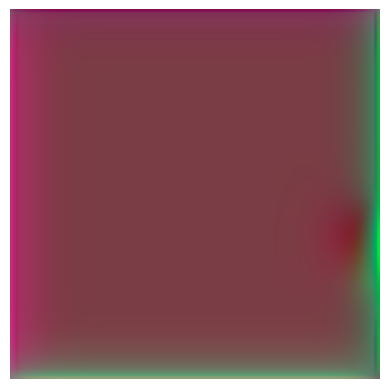

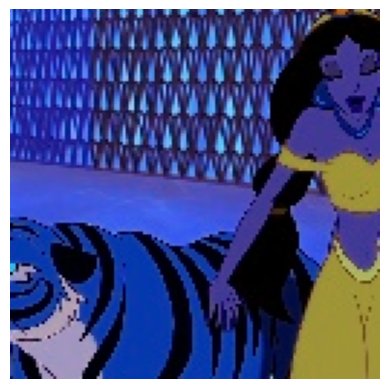

In [34]:
show(img_tensor, True)
show(y, True)